<a href="https://colab.research.google.com/github/vard-uhi/Customer-Lifetime-Value/blob/master/Customer_Lifetime_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#data manipulation, transformation
import pandas as pd 

#visualization
import matplotlib.pyplot as plt 
import seaborn as sns #visualization

#for scientific computations
import numpy as np 

#for train and test split
from sklearn.model_selection import train_test_split 

#model building in stats
import statsmodels.api as sm

#internal validity stastistical tests and plots
from statsmodels.api import qqplot #for qq plot
from statsmodels.stats.diagnostic import het_breuschpagan,linear_rainbow  #variance equality and linearity tests
from scipy.stats import shapiro #for checking normality
from statsmodels.stats.outliers_influence import variance_inflation_factor #for checking Multicolinearity
from sklearn.metrics import r2_score #R-squared

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#load the data
from google.colab import files
data_to_load = files.upload()

Saving CLV_data.xlsx to CLV_data.xlsx


In [ ]:
import io
# .read_csv() assigns the information from the initial *.csv file to this variable
raw_data = pd.read_excel(io.BytesIO(data_to_load['CLV_data.xlsx']))

In [ ]:
df = raw_data.copy()

#### **Descriptive analysis**

In [ ]:
df.head()

,Customer,State,Customer_Lifetime_Value,Response,Coverage,Education,Effective_To_Date,EmploymentStatus,Gender,Income,Location_Code,Marital_Status,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Policy_Type,Policy,Renew_Offer_Type,Sales_Channel,Total_Claim_Amount,Vehicle_Class,Vehicle_Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2011-02-24,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,2011-01-31,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2011-02-19,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,2011-01-20,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2011-02-03,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [ ]:
#data overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Customer                       9134 non-null   object        
 1   State                          9134 non-null   object        
 2   Customer_Lifetime_Value        9134 non-null   float64       
 3   Response                       9134 non-null   object        
 4   Coverage                       9134 non-null   object        
 5   Education                      9134 non-null   object        
 6   Effective_To_Date              9134 non-null   datetime64[ns]
 7   EmploymentStatus               9134 non-null   object        
 8   Gender                         9134 non-null   object        
 9   Income                         9134 non-null   int64         
 10  Location_Code                  9134 non-null   object        
 11  Marital_Status   

In [ ]:
df.describe()

,Customer_Lifetime_Value,Income,Monthly_Premium_Auto,Months_Since_Last_Claim,Months_Since_Policy_Inception,Number_of_Open_Complaints,Number_of_Policies,Total_Claim_Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678


In [ ]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:", df.duplicated().sum())
print("Missing values:", df.isna().sum().sum())
print("Single valued columns:", df.columns[df.nunique()==1])

Duplicates: 0
Missing values: 0
Single valued columns: Index([], dtype='object')


In [ ]:
# Let's drop some columns:
# Customer (as this is juat an ID and should not affect CLV)
# Effective_To_Date (as this is date and to include we should extract month or year or else from it)
drops = ["Customer","Effective_To_Date"]
data = df.drop(drops,axis=1)

**Visualizations**

Let's outline some questions that might be insightful from CLV analytics point.

* Relationship between CLV and Income.
* Is CLV different by Gender, Marital Status? 
* Income by Vehicle class/size

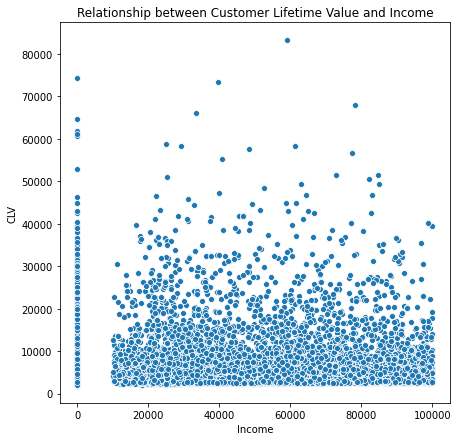

In [ ]:
#Let's plot scatterplot of CLV and Income
plt.figure(figsize=(7,7))
sns.scatterplot(data.Income,data.Customer_Lifetime_Value,)
plt.xlabel("Income")
plt.ylabel("CLV")
plt.title("Relationship between Customer Lifetime Value and Income")
plt.show()

In [ ]:
#We can see a lot of customers having 0 income.
#As wee see, all of them are unemployed
data["EmploymentStatus"][data.Income==0].value_counts()

Unemployed    2317
Name: EmploymentStatus, dtype: int64

In [ ]:
#As we have pretty much 0s in the data, to avoid errors, we will use np.log1p
print("\n","Natural log:",np.log(0),"\n","Natural log +1:",np.log(0+1),"\n","Np.log1p:",np.log1p(0))


 Natural log: -inf 
 Natural log +1: 0.0 
 Np.log1p: 0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


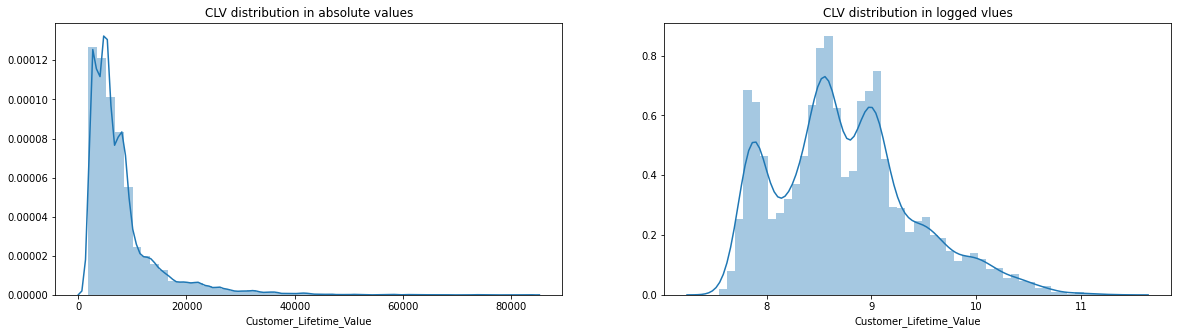

In [ ]:
#let's visualise the distribution of CLV vs log(CLV)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
sns.distplot(data.Customer_Lifetime_Value)
plt.title("CLV distribution in absolute values")

plt.subplot(1,2,2)
sns.distplot(np.log1p(data.Customer_Lifetime_Value))
plt.title("CLV distribution in logged vlues")

plt.show()

As it can be seen, we have a right-skewed data of a large scale and the log(Price) distribution changed the situation to better one.

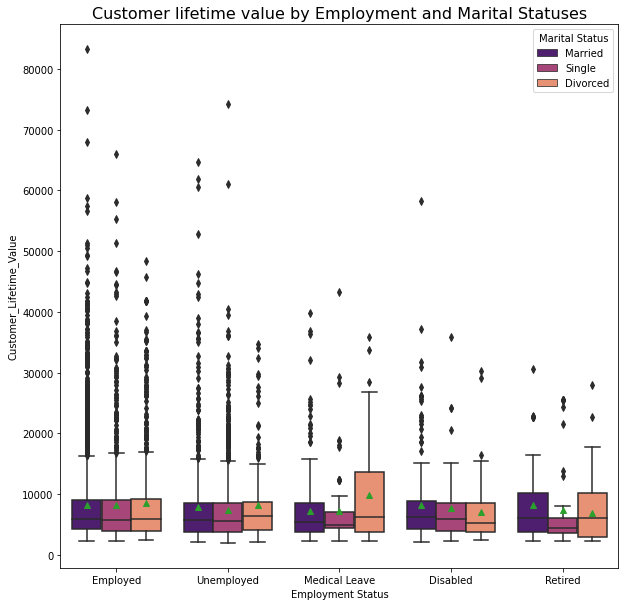

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(x='EmploymentStatus', y='Customer_Lifetime_Value', data=data, palette='magma',hue=data.Marital_Status, showmeans=True)
plt.legend(title='Marital Status', loc='upper right')
plt.xlabel("Employment Status")
plt.title('Customer lifetime value by Employment and Marital Statuses',fontdict={'fontsize':16})
plt.show()

As we see, there is no interaction term of marital and employment statuses on CLV, mean values are almost the same.

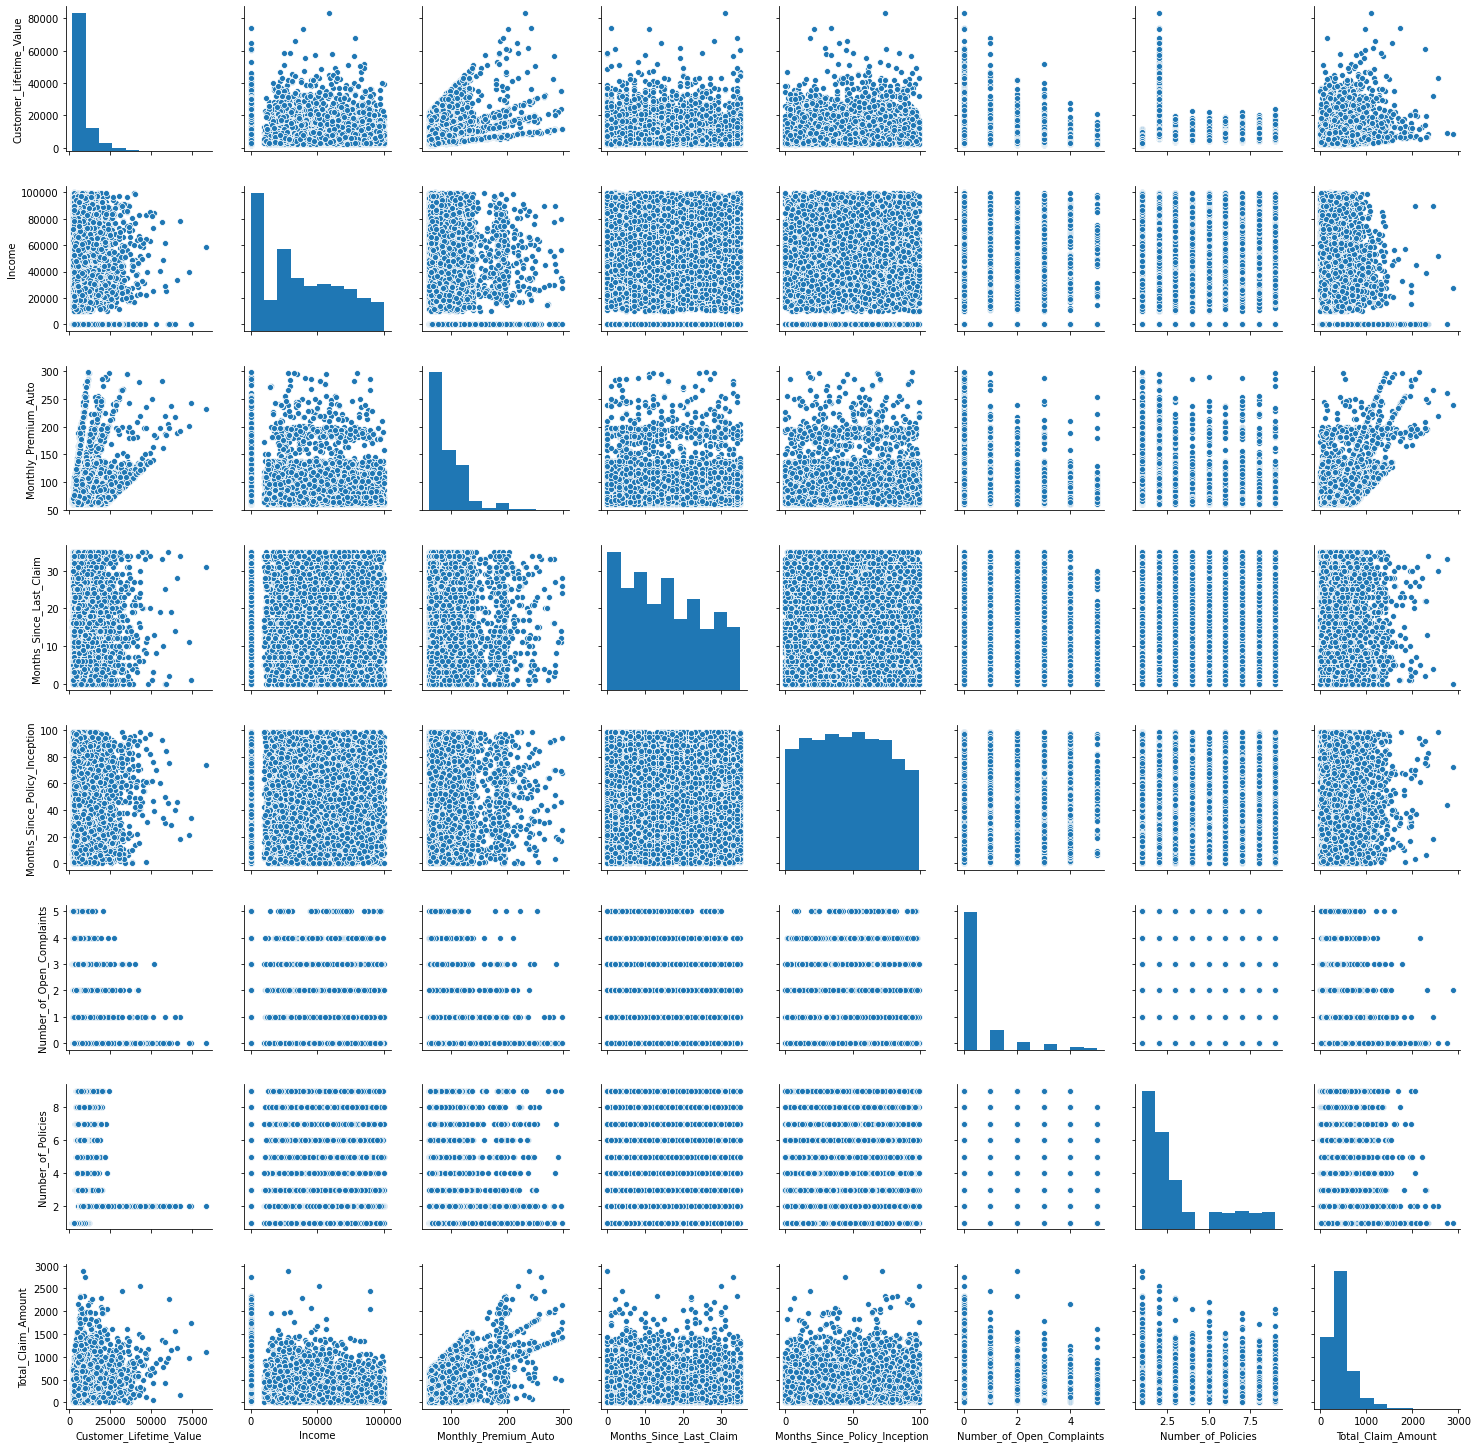

In [ ]:
#To see the visual representation of pairwise relationships in a dataset, a pairplot is used. Note that it only plots numeric
#columns.
sns.pairplot(data)

We can clearly see a positive relationship between CLV and Monthly_premium_auto.It is also notable that the value of 2 for "Number_of_Policies" is significantly different from others.

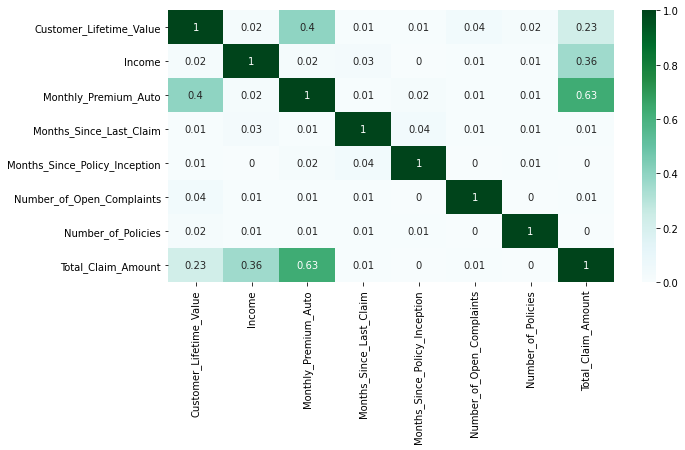

In [ ]:
#Let's visualize correlations
plt.figure(figsize=(10,5))
sns.heatmap(data.corr().abs().round(2),annot=True, cmap = "BuGn")
plt.show()

The correlation matrix shows that "Number_of_Policies","Total_Claim_Amount","Monthly_Premium_Auto", "Number_of_Open_Complaints", "Income" have the highest correlation with CLV.



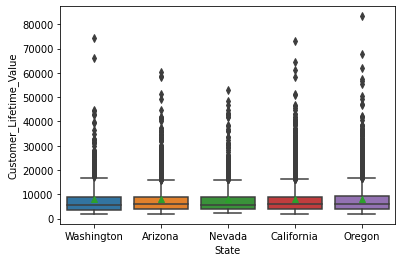

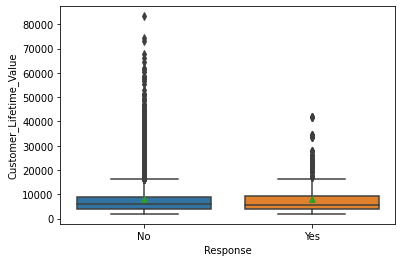

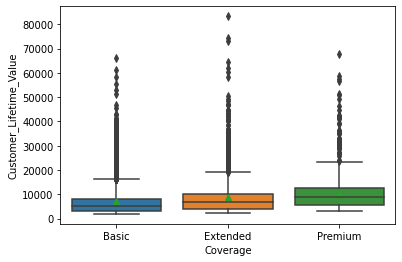

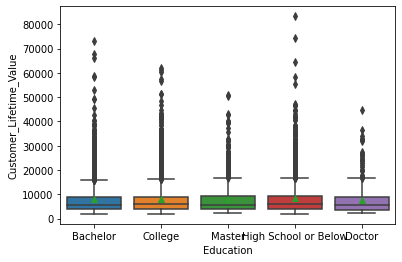

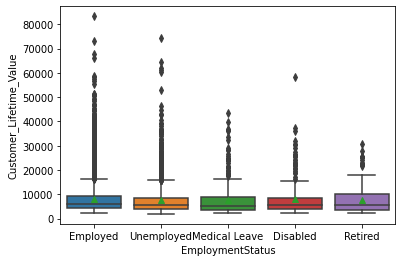

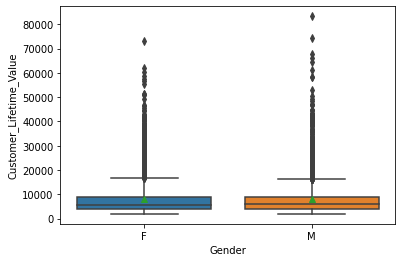

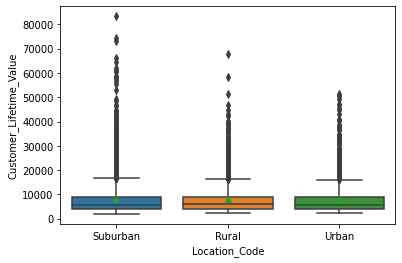

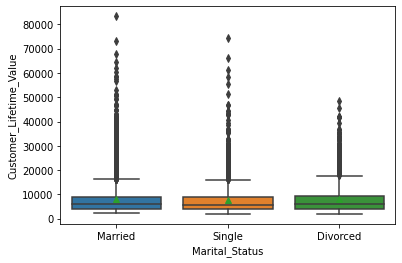

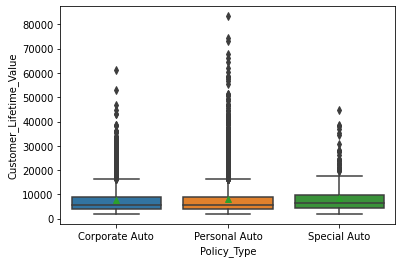

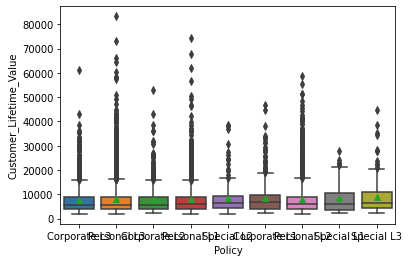

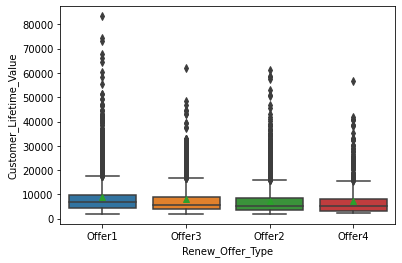

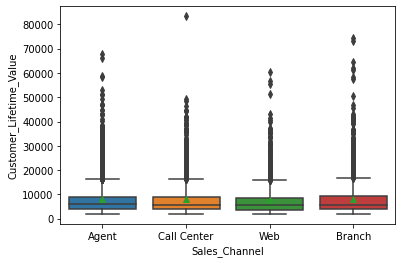

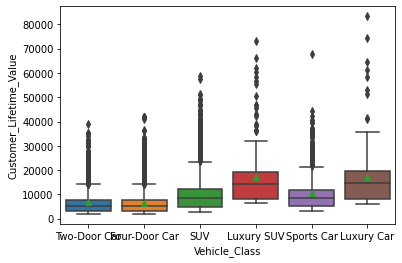

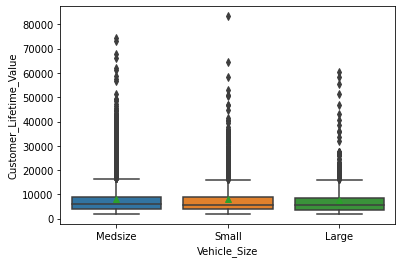

In [ ]:
#Let's also see whether mean CLV differs by any of the categorical variables.
#to see that, let's visualize CLV by each categorical variable represented in boxplot.
categoricals=data.dtypes[data.dtypes=="O"].index.tolist()
for i in categoricals:
    sns.boxplot(data=data,x=i,y="Customer_Lifetime_Value", showmeans=True)
    plt.show()

As it can be seen, visually CLV is significantly different for only some levels of several categorical variables, specifically: "Premium" of Coverage,"Employed" of EmploymentStatus,"Luxury SUV" of Vehicle Class. Thus let's build a model for the noted covariates and the ones having highest correlation with CLV and disregard all the other levels of categorical variables, based on visual evidence and in order to avoid a lot of columns with not significant p-values.

#### **ML MOdel**

In [ ]:
#separating X and Y
target = data.Customer_Lifetime_Value
inputs = data.drop(['Customer_Lifetime_Value'],axis=1)

In [ ]:
#let's outline only several variables as discussed above and build model on them
selected_covariates = ['Number_of_Policies','Total_Claim_Amount', 'Number_of_Open_Complaints','EmploymentStatus','Coverage','Vehicle_Class']

In [ ]:
#log-transforming Customer Lifetime Value
target = np.log1p(target)
inputs = inputs[selected_covariates]
inputs.head()

,Number_of_Policies,Total_Claim_Amount,Number_of_Open_Complaints,EmploymentStatus,Coverage,Vehicle_Class
0,1,384.811147,0,Employed,Basic,Two-Door Car
1,8,1131.464935,0,Unemployed,Extended,Four-Door Car
2,2,566.472247,0,Employed,Premium,Two-Door Car
3,7,529.881344,0,Unemployed,Basic,SUV
4,1,138.130879,0,Employed,Basic,Four-Door Car


In [ ]:
#transforming the selected covariates
inputs["Number_of_Policies_1"] = np.where(inputs.Number_of_Policies==1,1,0) #making a dummy variable when # of policies=1
inputs["Number_of_Policies"] = np.where(inputs.Number_of_Policies==2,1,0) #making a dummy variable when # of policies=2
inputs["EmploymentStatus"] = np.where(inputs.EmploymentStatus=="Employed",1,0) #outlining Employed customers
inputs["Coverage"] = np.where(inputs.Coverage=="Premium",1,0) #outlining Premium coverage

In [ ]:
#getting dummies
inputs = pd.get_dummies(inputs, drop_first=True)

In [ ]:
#adding constraint to X
inputs = sm.add_constant(inputs)

In [ ]:
inputs.head()

,const,Number_of_Policies,Total_Claim_Amount,Number_of_Open_Complaints,EmploymentStatus,Coverage,Number_of_Policies_1,Vehicle_Class_Luxury Car,Vehicle_Class_Luxury SUV,Vehicle_Class_SUV,Vehicle_Class_Sports Car,Vehicle_Class_Two-Door Car
0,1.0,0,384.811147,0,1,0,1,0,0,0,0,1
1,1.0,0,1131.464935,0,0,0,0,0,0,0,0,0
2,1.0,1,566.472247,0,1,1,0,0,0,0,0,1
3,1.0,0,529.881344,0,0,0,0,0,0,1,0,0
4,1.0,0,138.130879,0,1,0,1,0,0,0,0,0


In [ ]:
#splitting the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size = 0.2, random_state=42)

In [ ]:
#observing the results
results = sm.OLS(y_train, x_train).fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Customer_Lifetime_Value   R-squared:                       0.868
Model:                                 OLS   Adj. R-squared:                  0.868
Method:                      Least Squares   F-statistic:                     4350.
Date:                     Wed, 02 Sep 2020   Prob (F-statistic):               0.00
Time:                             11:34:29   Log-Likelihood:                 175.25
No. Observations:                     7307   AIC:                            -326.5
Df Residuals:                         7295   BIC:                            -243.7
Df Model:                               11                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          8.5336      0.009    969.394      0.000       8.516       8.551
Number_of_Policies             0.7063      0.007    100.119      0.000       0.692       0.720
Total_Claim_Amount             0.0001   1.32e-05      8.217      0.000    8.23e-05       0.000
Number_of_Open_Complaints     -0.0223      0.003     -7.345      0.000      -0.028      -0.016
EmploymentStatus               0.1131      0.006     17.964      0.000       0.101       0.125
Coverage                       0.3397      0.010     33.825      0.000       0.320       0.359
Number_of_Policies_1          -0.6905      0.006   -107.738      0.000      -0.703      -0.678
Vehicle_Class_Luxury Car       0.8909      0.023     39.277      0.000       0.846       0.935
Vehicle_Class_Luxury SUV       0.9288      0.022     42.674      0.000       0.886       0.971
Vehicle_Class_SUV              0.4244      0.008     53.903      0.000       0.409       0.440
Vehicle_Class_Sports Car       0.4582      0.013     35.849      0.000       0.433       0.483
Vehicle_Class_Two-Door Car     0.0002      0.007      0.022      0.982      -0.014       0.014
==============================================================================
Omnibus:                     1483.880   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3693.777
Skew:                           1.117   Prob(JB):                         0.00
Kurtosis:                       5.672   Cond. No.                     4.81e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretation of the results of Linear Regression for log(CLV)**

***Note: As we have log-linear model, to interpret the effect of significant independent variable on CLV you should multiply coefficient estimate with 100 and interpret the result in %. I.e. for Total_Claim_Amount it will be the following: 1 unit change in Total_Claim_Amount leads to 100*0.0001=0.01‬% percent change in CLV.***



*   **R-squared and F-statistics:** As Prob (F-statistic) shows our model is statistically significant at 5% significance level, so there is at least one estimated coefficient (besides intercept) that is not null. R-squared is quite big number and it shows that 86.8% of variance in log(CLV) is explained by the variables included in the model.
*   **Adj. R-squared:** As summary shows it's the same as R-squared, 86.8% which means that we have a very consistent model.
* **Statistically significant variables:** As p-values of t-statistics show, all variables included in the model are statistically significant at 5% sig. level (p<=0.05).
* **Coefficients (continous variable):** Let's interpret for Total_Claim_Amount. For each unit increase in Total_Claim_Amount we will experience on average about 0.0001 dollars increase in mean log(CLV).
* **Coefficients (categorical variable):** Let's interpret for Vehicle_Class, Luxury SUV subclass. If a car has "Luxury SUV" class rather than "Four-Door Car" then on average 0.9270 dollars increase is expected in mean log(CLV).





In [ ]:
#predicting for train and test data
y_test_linear = results.predict(sm.add_constant(x_test))
y_train_linear = results.predict(x_train)

In [ ]:
#let's see r-squared for train and test sets for the initial model
print("R-squared Train:",r2_score(y_train,y_train_linear))
print("R-squared Test:",r2_score(y_test, y_test_linear))

R-squared Train: 0.8677009909030928
R-squared Test: 0.8696389094851944


#### **Checking Linear Regression assumptions using residual analysis**

To check the assumptions using residual analysis we will plot the fitted values vs error terms (residuals). It should not exhibit any patterns (should be randomly distributed) to meet the Linearity, Normality and Independence assumptions.

In [ ]:
#residuals of the model
residuals = results.resid
predicted_values = results.predict()

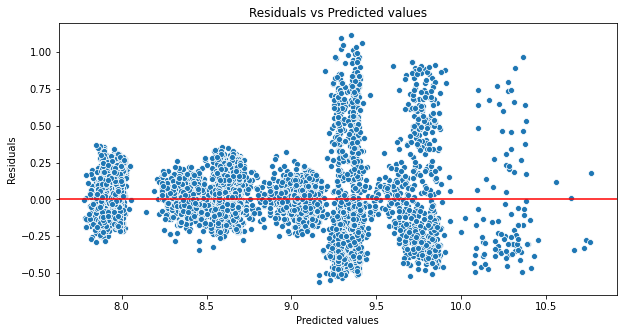

In [ ]:
#lets plot predicted values vs residuals
plt.figure(figsize=(10,5))
sns.scatterplot(predicted_values,residuals)
plt.axhline(y=0, c="red")
plt.title("Residuals vs Predicted values")
plt.ylabel("Residuals")
plt.xlabel("Predicted values")
plt.show()

The residuals vs fitted values plot pattern is not totally random and we can see groups of observations scattered together around some points. We also observe a very high variance from the left to the right.

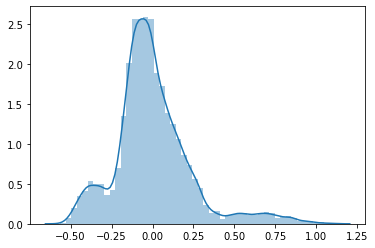

In [ ]:
#Normality
#visual presentation- histogram
sns.distplot(residuals)
plt.show()

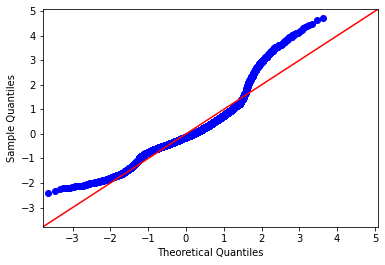

In [ ]:
#QQ plot
qqplot(residuals,fit=True, line='45')
plt.show()

The residuals distribution plot shows that the distribution is not normal. QQ-plot shows a nonlinear pattern too.

**Diagnostic tests for Linear Regression assumptions**

In [ ]:
#Linearity 
#The null hypothesis assumes that the regression is correctly modelled as linear
rnames=["fstat", "p-value"]
rainbow=linear_rainbow(results)
print(list(zip(rnames, rainbow)))

[('fstat', 1.03034429644821), ('p-value', 0.18337453055366773)]


Linearity assumption is held at 5% significance level (p-value = 0.15 > 0.05).

In [ ]:
#Breusch-Pagan test for homoscedasticity
#The null hypothesis assumes homoskedasticity
bnames = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
breush = het_breuschpagan(residuals, results.model.exog)
print(list(zip(bnames, breush)))

[('Lagrange multiplier statistic', 2444.3773139384866), ('p-value', 0.0), ('f-value', 333.3728927861971), ('f p-value', 0.0)]


We reject the null hypothesis based on 5% significance level, thus homoscedasticity assumption is not held.

In [ ]:
#Shapiro-Wilk normality test. 
#The null-hypothesis of this test is that the data was drawn from a normal distribution
snames=['The test statistic', 'p-value']
shapiro=shapiro(residuals)
print(list(zip(snames, shapiro)))

[('The test statistic', 0.9240202903747559), ('p-value', 0.0)]


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Test confirms that the data was not drawn from a normal distribution.

In [ ]:
#defining colnames 
var = inputs.columns.tolist()

In [ ]:
#Multicollinearity
#calculating vif using variance_inflation_factor() function from statsmodel
vif = [variance_inflation_factor(inputs[var].values, i) for i in range(0,len(var))]
print(vif)

[10.175796997538532, 1.2287663729197085, 1.914462011285641, 1.0011289898280675, 1.2167941864553364, 1.099024842319904, 1.2285774602422934, 1.2580524624567293, 1.258959759440782, 1.2812306121252206, 1.0914045072326592, 1.1179072631500433]


In [ ]:
#printing vif values together with variable names
for i in range(0,len(var)):
    print(var[i],":",vif[i])

const : 10.175796997538532
Number_of_Policies : 1.2287663729197085
Total_Claim_Amount : 1.914462011285641
Number_of_Open_Complaints : 1.0011289898280675
EmploymentStatus : 1.2167941864553364
Coverage : 1.099024842319904
Number_of_Policies_1 : 1.2285774602422934
Vehicle_Class_Luxury Car : 1.2580524624567293
Vehicle_Class_Luxury SUV : 1.258959759440782
Vehicle_Class_SUV : 1.2812306121252206
Vehicle_Class_Sports Car : 1.0914045072326592
Vehicle_Class_Two-Door Car : 1.1179072631500433


As we see there is no multicollinearity issue for this model.